In [4]:
# Import modules
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Programs":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")

work_dir = work_space(os.getcwd())
data_path = work_dir + "/Hub/VariableData/"
folders = os.listdir(data_path)
data_files = [data_path + data_file for data_file in folders]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [2, 18, 3]
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal'
        }

filenames_dict = {
    "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL": "Sphal1",
    "PP13-Sphaleron-THR9-FRZ15-NB33-60-NSUBP50": "Sphal2",
    "PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5": "Sphal3",
    "BH_n4_M8": "BH1",
    "BH_n4_M9": "BH2",
    "BH_n4_M9_Mpl9": "BH3",
    "BH_n4_M10": "BH4",
    "BH_n4_M11": "BH5",
    "BH_n4_M12": "BH6",
    "BH_n5_M8": "BH7",
    "BH_n5_M9": "BH8",
    "BH_n5_M10": "BH9",
    "BH_n5_M11": "BH10",
    "BH_n5_M12": "BH11",
    "BH_n6_M8": "BH12",
    "BH_n6_M9": "BH13",
    "BH_n6_M10": "BH14",
    "BH_n6_M11": "BH15",
    "BH_n6_M12": "BH16",
    "BlackMaxOutputFirstRun1": "BH17",
    "BlackMaxOutputFirstRun2": "BH18",
    "ttbar_largejet": "ttbar1",
    "ttbar": "ttbar2"
}


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def efficiencies_data(efficiency_data, binsize, max_eff):
    folder_binned_data = [[(data_binner(dataframe, binsize, plot = False)) for dataframe in dataframes] for dataframes in efficiency_data]
    folder_binned_xs = [[data[0] for data in binned_data] for binned_data in folder_binned_data]
    folder_binned_ys = [[data[1] for data in binned_data] for binned_data in folder_binned_data]

    x_interval = np.unique(unpacker(folder_binned_xs, []))
    x_min, x_max = np.min(x_interval), np.max(x_interval)
    bins = int(np.round((x_max - x_min) / binsize))
    x = [x_min + (bin + 1)*binsize for bin in range(bins + 1)]

    left_efficiencies = []
    right_efficiencies = []

    for folder_index, binned_ys in enumerate(folder_binned_ys):
        temp_left_efficiencies = [[] for ys in binned_ys]
        temp_right_efficiencies = [[] for ys in binned_ys]
        for dataframe_index, y in enumerate(binned_ys):
            for bin in range(bins + 1):
                y_left = y[:bin + 1]
                y_right = y[bin + 1:]
                y_split = [y_left, y_right] if folder_index == 0 else [y_right, y_left]
                
                for i in range(len(["left", "right"])):
                    efficiency = np.sum(y_split[i])
                    if i == 0:
                        temp_left_efficiencies[dataframe_index].append(efficiency)
                    else:
                        temp_right_efficiencies[dataframe_index].append(efficiency)
        left_efficiencies.append(temp_left_efficiencies)
        right_efficiencies.append(temp_right_efficiencies)
    
    if max_eff:
        sphal_left_efficiencies = left_efficiencies[1][0]
        sphal_right_efficiencies = right_efficiencies[1][0]

        bh_left_sphal_right = []
        for bh_left_efficiencies in left_efficiencies[0]:
            efficiencies = zip(bh_left_efficiencies, sphal_left_efficiencies)
            efficiencies = [np.sum(efficiency) for efficiency in efficiencies]
            bh_left_sphal_right.append(efficiencies)
        
        bh_right_sphal_left = []
        for bh_right_efficiencies in right_efficiencies[0]:
            efficiencies = zip(bh_right_efficiencies, sphal_right_efficiencies)
            efficiencies = [np.sum(efficiency) for efficiency in efficiencies]
            bh_right_sphal_left.append(efficiencies)
        
        eff_tupes = []
        for tupled_efficiencies in zip(bh_left_sphal_right, bh_right_sphal_left):
            tupled_efficiencies = [(np.max(efficiencies), efficiencies.index(np.max(efficiencies)), index) for index, efficiencies in enumerate(tupled_efficiencies)]
            max_efficiency = sorted(tupled_efficiencies, key = lambda x: x[0])[-1]
            me_value = max_efficiency[0] / 2
            me_dir = max_efficiency[2]
            me_bin = max_efficiency[1]
            me_x = x_min + me_bin * binsize
            eff_tupes.append([me_x, me_value, me_dir])
    
        return [(x, left_efficiencies), (x, right_efficiencies)], eff_tupes
        
    else:
        return [(x, left_efficiencies), (x, right_efficiencies)]


def data_binner(data, binsize, plot):
    data = unpacker(data, [])

    if len(data) == 0:
        x = [bin * binsize for bin in range(200)]
        y = [0 for bin in range(200)]
        return x, y

    max_value = np.max(data)
    bins = int(np.round(max_value / binsize))
    bins = np.arange(0, bins)
    data = np.array(data)
    x, y = [], []

    if plot:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            if len(temp) != 0:
                y.append(len(temp))
                x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y
    else:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            y.append(len(temp))
            x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y


def plot_filter(interval_data, filter_strength):
    interval_data = sorted(interval_data)
    cutoff = round((len(interval_data) * filter_strength))
    interval_data = interval_data[:cutoff]
    x_min = np.min(interval_data)
    x_max = np.max(interval_data)
    extra = (x_max - x_min) / 10
    return [x_min - extra, x_max + extra]


def dropper(dataframe, data_variables):
    to_drop = [col for col in dataframe.columns if col not in data_variables]
    dataframe = dataframe.drop(to_drop, axis = 1)
    return dataframe


def dataframe_retriever(data_path, data_variables):
    from natsort import natsorted, ns
    folders = os.listdir(data_path)
    folder_filenames = [natsorted([filename for filename in os.listdir(data_path + folder)], key = lambda y: y.lower()) for folder in folders]
    folder_filepaths = [[data_path + folder + "/" + filename for filename in folder_filenames[folder_index]] for folder_index, folder in enumerate(folders)]
    folder_filenames = [[filenames_dict[filename[:-len(".csv")]] for filename in filenames] for filenames in folder_filenames]
    dataframes = [[(pd.read_csv(filepath).drop("Unnamed: 0", axis = 1), filename) for filepath, filename in zip(filepaths, filenames)] for filepaths, filenames in zip(folder_filepaths, folder_filenames)]
    return dataframes


def sampler(model_dataframes, file_amounts, data_variables):
    from random import sample
    dataframe_tuples = []
    for file_amount, dataframes in zip(file_amounts, model_dataframes):
        dataframe_tuples.append(sample(dataframes, file_amount)) if type(file_amount) == int else dataframe_tuples.append([dataframe for dataframe in dataframes if dataframe[1] in file_amount])
    
    dataframe_tuples = [sorted(dataframes, key = lambda x: int(x[1][len(string):])) for dataframes, string in zip(dataframe_tuples, ["ttbar", "bh", "sphal"])]
    
    foldered_filenames = [[dataframe[1] for dataframe in dataframes] for dataframes in dataframe_tuples]
    foldered_dataframes = [[dropper(dataframe[0], data_variables) for dataframe in dataframes] for dataframes in dataframe_tuples]

    return foldered_dataframes, foldered_filenames


def plotter(data_variables, dataframes_input, labels, filter_strengths, binsizes, max_eff):
    locations = ["center left", "center right", "center right", "center right", "center left"]

    for variable_index, variable in enumerate(data_variables):
        fig = plt.figure(figsize = (12, 6))
        style = "seaborn-v0_8-darkgrid"
        plt.style.use(style)

        titles = ["$H_T$", "MET", "Phi Difference (Largest $P_T$ vs MET)", "Max $P_T$", "Object Multiplicity"]
        xlabels = ["[GeV/c]", "[GeV]", "[Radians]", "[GeV/c]", ""]
        title = titles[variable_index] + " Separability Distribution"
        fig.suptitle(title, fontdict = font, fontsize = 16)
        subplots = fig.subplots(1, 2)
        
        raw_data = [[dataframe[variable] for dataframe in dataframes] for dataframes in dataframes_input]
        binsize = binsizes[variable_index] if type(binsizes) == list else binsizes
        filter_strength = filter_strengths[variable_index] if type(filter_strengths) == list else filter_strengths
        interval = np.concatenate(unpacker(raw_data, []))
        xlim = plot_filter(interval, filter_strength)
        loc = locations[variable_index]

        if max_eff:
            plots_data, eff_tupes = efficiencies_data(raw_data, binsize, max_eff)
        else:
            plots_data = efficiencies_data(raw_data, binsize, max_eff)

        ax = subplots[0]
        if variable_index == 0:
            ax.set_title("Separabilities of BH vs Sphal", fontdict = font, fontsize = 16)
        ax.set_xlim(xlim)
        ax.set_xlabel(titles[variable_index] + xlabels[variable_index], fontdict = font, fontsize = 12)
        ax.set_ylabel("Separability", fontdict = font, fontsize = 12)
        plot_labels = [[filename + " to the " + "left" if folder_index == 0 else filename + " to the " + "right" for filename in filenames] for folder_index, filenames in enumerate(labels)]
        
        x = plots_data[0][0]
        for folder_index, ys in enumerate(plots_data[0][1]):
            for plot_index, y in enumerate(ys):
                ax.plot(x, y, label = plot_labels[folder_index][plot_index])
                if max_eff:
                    eff_tupe = eff_tupes[plot_index]
                    me_x, me_value, me_dir = eff_tupe
                    relation = "BH < Sphal" if me_dir == 0 else "BH > Sphal"
                    ax.vlines(me_x, ymin = 0, ymax = 1)
            ax.legend(prop = {'size': 8}, loc = loc)

        ax = subplots[1]
        if variable_index == 0:
            ax.set_title("Separabilities of BH vs Sphal", fontdict = font, fontsize = 16)
        ax.set_xlim(xlim)
        ax.set_xlabel(titles[variable_index] + xlabels[variable_index], fontdict = font, fontsize = 12)
        plot_labels = [[filename + " to the " + "right" if folder_index == 0 else filename + " to the " + "left" for filename in filenames] for folder_index, filenames in enumerate(labels)]

        for folder_index, ys in enumerate(plots_data[1][1]):
            for plot_index, y in enumerate(ys):
                ax.plot(x, y, label = plot_labels[folder_index][plot_index])
                if max_eff:
                    eff_tupe = eff_tupes[plot_index]
                    me_x, me_value, me_dir = eff_tupe
                    relation = "BH < Sphal" if me_dir == 0 else "BH > Sphal"
                    ax.vlines(me_x, ymin = 0, ymax = 1)
            ax.legend(prop = {'size': 8}, loc = loc)

        plt.tight_layout
        plt.show()

In [5]:
from FilesFunc import files
folder_list, filename_list = files(data_path, folders, file_amounts)

folder_dataframes = dataframe_retriever(data_path, data_variables)

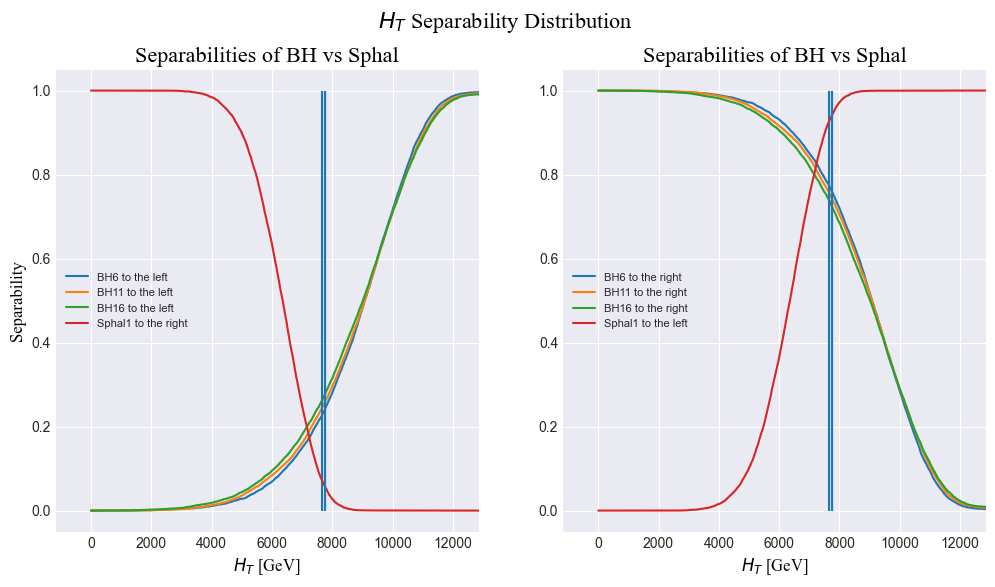

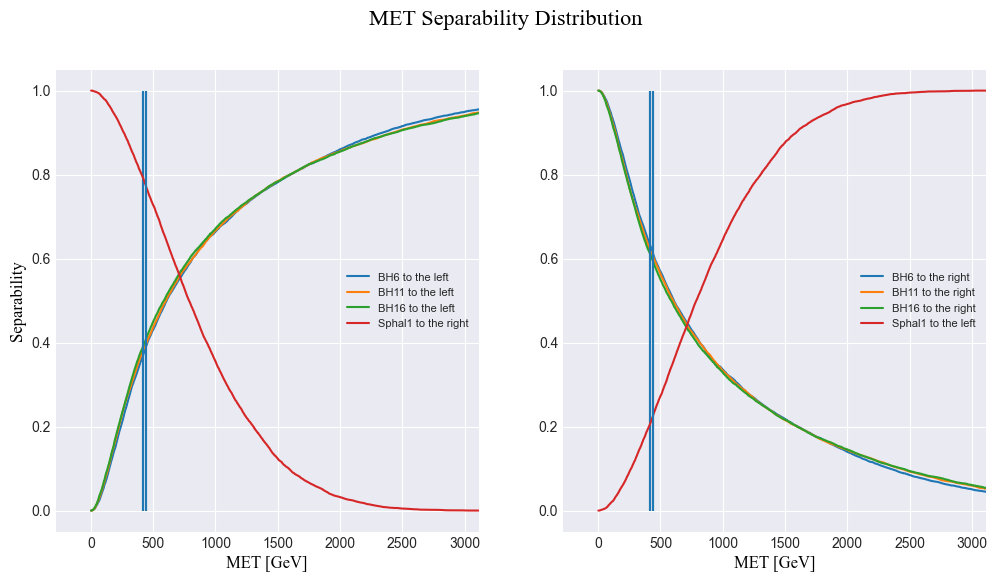

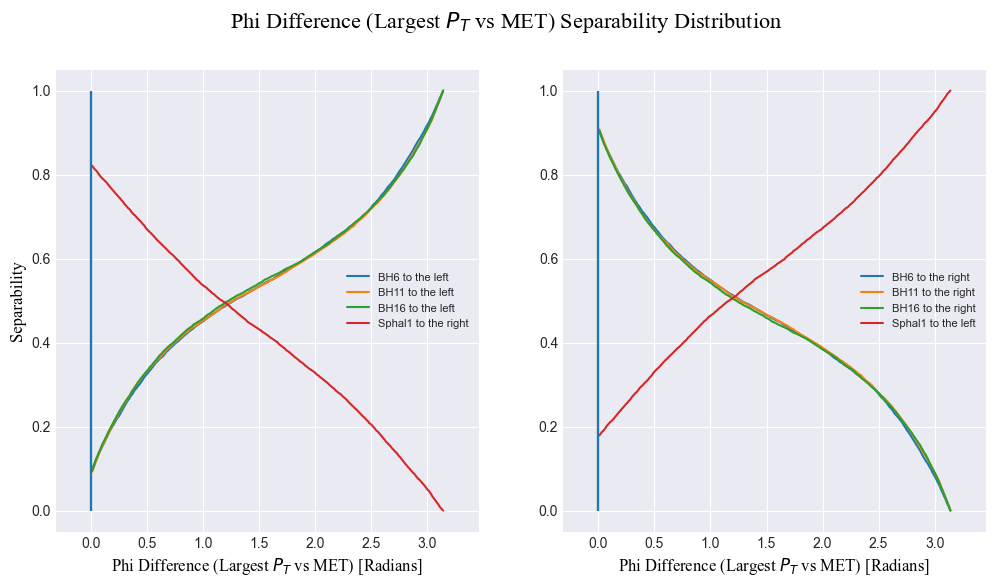

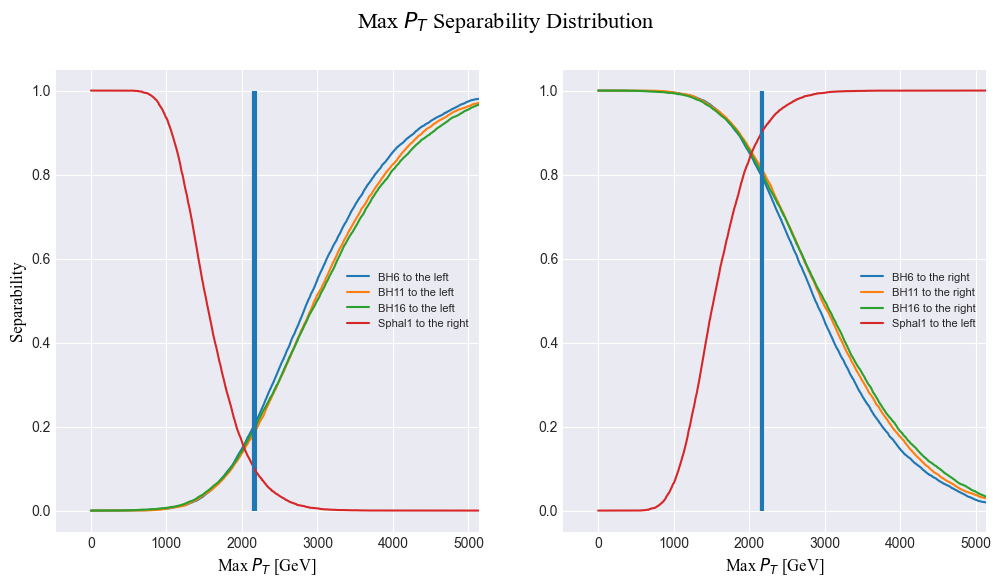

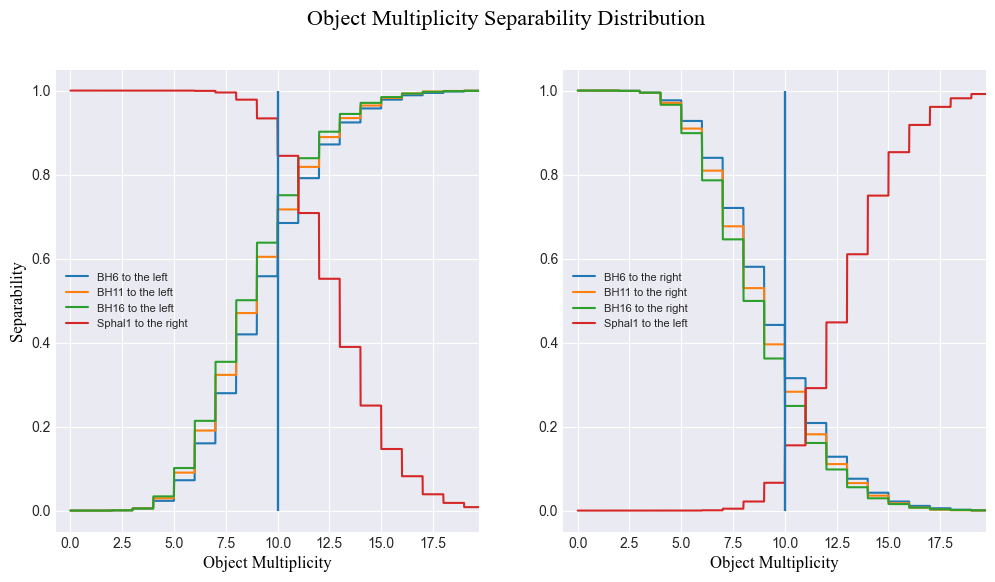

In [6]:
file_amounts = [0, ["BH6", "BH11", "BH16"], ["Sphal1"]]
dataframes_input, filenames_input = sampler(folder_dataframes, file_amounts, data_variables)
dataframes_input = [dataframes for dataframes in dataframes_input if len(dataframes) != 0]
filenames_input = [filenames for filenames in filenames_input if len(filenames) != 0]
plotter(data_variables, dataframes_input, filenames_input, filter_strengths = [0.975, 0.95, 1, 0.95, 0.99], binsizes = [1, 1, 0.01, 1, 0.01], max_eff = True)